## human_segmentation
### 인물사진 만들기
***
**Step 1. 인물모드 직접 해 보기**  
*여러분의 셀카를 이용해서 오늘 배운 내용을 수행해 봅시다.  
아래와 같은 이미지를 얻어야 합니다. 최소 3장 이상의 인물모드 사진을 만들어 봅시다.  
인물이 주인공이 아닌, 귀여운 고양이에 대한 아웃포커싱 사진도 만들어 볼 수 있을 것입니다.   
시맨틱 세그멘테이션 스텝에서 힌트를 찾아봅시다.  
배경을 blur하는 인물모드 사진이 아니라 배경사진을 다른 이미지로 교체하는 크로마키 배경합성을 시도해 볼 수도 있을 것입니다.   
여러분만의 환상적인 사진을 만들어 보면 어떨까요?*

**Step 2. 사진에서 문제점 찾기**  
*아래 사진에도 문제점이 몇가지 있었습니다.  
예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지지 않고 나온다던가 하는 경우입니다.  
ㅠㅠ 그 외 다른 문제들이 눈에 띄시나요? 아래 사진에는 이상한 점이 최소 2개 이상 더 있습니다. 어떤 문제가 있는지 찾아서 아래 사진처럼 표시해 봅시다.  
추가로 여러분이 만들어 낸 인물 모드 사진 중 하나에서도 이상한 위치를 찾아 아래 사진처럼 표시해 봅시다.  
표시한 이미지들을 jupyter notebook에 포함하여 제출해 주세요.*

**Step 3. 해결 방법을 제안해 보기**  
*아주 간단히 멋진 카메라앱 서비스를 만들어 출시할 수 있을 것 같았지만, 지금같은 완성도로는 어림도 없습니다.  
소비자들의 눈높이는 그리 호락호락하지 않고, 엔지니어인 여러분들은 답을 찾아내야 합니다.*
***
### 평가문항  
**1. 인물모드 사진을 성공적으로 제작하였다.**  
    -아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.  
    
    
**2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.**  
    -인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.  
    
    
**3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.**  
    -추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.
***
**Step 1. 인물모드 직접 해 보기**

In [1]:
# 필요한 라이브러리 import
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
# import os
# img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/my_image.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
# img_orig = cv2.imread(img_path) 
# print (img_orig.shape)

In [3]:
# 이미지 가져오기
import os
dir_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/'

def image_dict(dir_path):
    image_list = os.listdir(dir_path)
    image_dict = {}
    img_orig={}
    cnt=0
    for file in image_list:
            img_path = os.path.join(dir_path, file)
            image_dict[cnt] = img_path
            img_orig[cnt]=cv2.imread(img_path)
            cnt+=1
    return image_dict, img_orig

image_dict, img_orig = image_dict(dir_path)

In [4]:
print("이미지 경로 : ",image_dict[2])
print("이미지 shape : ",img_orig[2].shape)

이미지 경로 :  /home/aiffel/aiffel/human_segmentation/images/dog.jpg
이미지 shape :  (467, 700, 3)


In [5]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [6]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [13]:
img_resized, seg_map = MODEL.run(img_orig[1])
print (img_orig[1].shape, img_resized.shape, seg_map.max())

(1224, 1632, 3) (384, 513, 3) 15


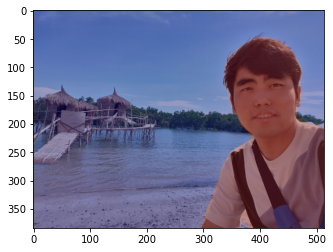

In [14]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [10]:
# img_resized, seg_map = MODEL.run(img_orig[2])
# print (img_orig[2].shape, img_resized.shape, seg_map.max())

(467, 700, 3) (342, 513, 3) 12


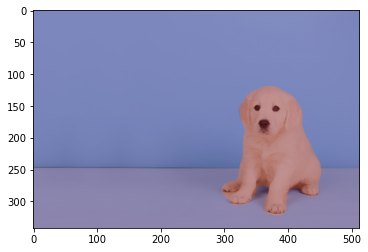

In [11]:
# img_show = img_resized.copy()
# seg_map = np.where(seg_map == 12, 12, 0) # 예측 중 사람만 추출
# img_mask = seg_map * (255/seg_map.max()) # 255 normalization
# img_mask = img_mask.astype(np.uint8)
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
# img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

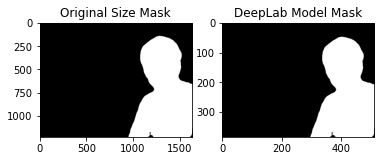

In [16]:
img_mask_up = cv2.resize(img_mask, img_orig[1].shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

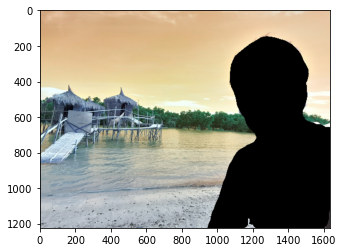

In [18]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig[1], img_bg_mask)
plt.imshow(img_bg)
plt.show()

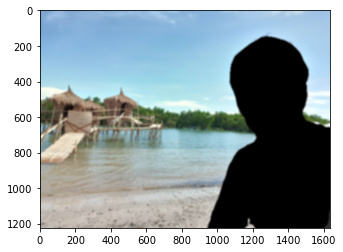

In [19]:
img_bg_blur = cv2.blur(img_bg, (13,13))
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

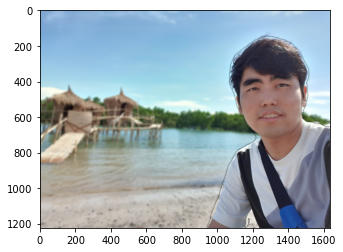

In [21]:
img_concat = np.where(img_mask_color==255, img_orig[1], img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()